<a href="https://colab.research.google.com/github/smallcats/TopicalLanguageModels/blob/master/Neural_TLM_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%tensorflow_version 1.x

import numpy as np

import nltk
from nltk.corpus import stopwords
import re

from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Lambda, Concatenate, Reshape, Dot
from keras.models import Model
import keras.backend as K

from gensim.models import Word2Vec

from matplotlib import pyplot as plt

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15.x`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [16]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
thurs = nltk.corpus.gutenberg.raw('chesterton-thursday.txt')
len(thurs)

320525

In [6]:
thurs = thurs.split('\n\n')
len(thurs)

1304

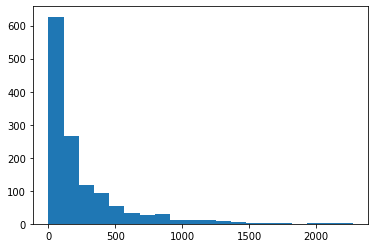

In [7]:
plt.hist([len(d) for d in thurs], bins=20)
plt.show()

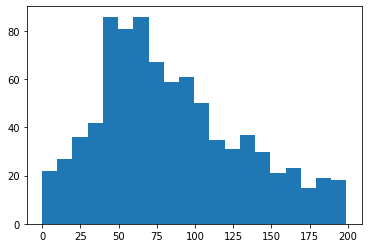

In [8]:
plt.hist([len(d) for d in thurs if len(d)<200], bins=20)
plt.show()

In [9]:
len([d for d in thurs if len(d)>75])

876

In [0]:
thurs = [d for d in thurs if len(d)>75]

In [0]:
thurs = [' '.join(d.split()) for d in thurs]

In [12]:
thurs[10]

'"Nonsense!" said Gregory, who was very rational when anyone else attempted paradox. "Why do all the clerks and navvies in the railway trains look so sad and tired, so very sad and tired? I will tell you. It is because they know that the train is going right. It is because they know that whatever place they have taken a ticket for that place they will reach. It is because after they have passed Sloane Square they know that the next station must be Victoria, and nothing but Victoria. Oh, their wild rapture! oh, their eyes like stars and their souls again in Eden, if the next station were unaccountably Baker Street!"'

In [0]:
thurs_sent = '\n'.join(thurs)
thurs_sent = nltk.tokenize.sent_tokenize(thurs_sent)

In [0]:
def doc2words(doc):
  words = nltk.tokenize.word_tokenize(doc)
  words = [w.lower() for w in words if w.isalpha()]
  words = [w for w in words if (len(w)>1) and (w not in stopwords)]
  return words

In [0]:
thurs_sent = [doc2words(s) for s in thurs_sent]

In [0]:
emb = Word2Vec(thurs_sent)

In [20]:
emb.wv.similar_by_word('door')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('eyes', 0.9963647127151489),
 ('street', 0.9962827563285828),
 ('upon', 0.9962505102157593),
 ('like', 0.9962358474731445),
 ('marquis', 0.9962334632873535),
 ('last', 0.9962024688720703),
 ('quite', 0.9961917400360107),
 ('little', 0.9961829781532288),
 ('whole', 0.9961309432983398),
 ('went', 0.9961091876029968)]

In [0]:
we = {w:emb.wv.get_vector(w) for w in emb.wv.vocab}
vec_size = emb.vector_size

In [0]:
def multiples(it, n):
  for k in range(len(it)-n+1):
    yield it[k:k+n]

class TopicalLanguageModel:
  """
  Neural Topical Language Model.

  attributes:
  num_topics :: int : number of topics
  doc2words :: function : takes a document as a string and returns words
  word_embedding :: dict : keys are words, values are vectors
  vector_size :: int : the dimension of embedding vectors
  lm_length :: int : length of tokens taken into account for character-level language models 
  """
  def __init__(self, num_topics, word_embedding, vector_size, doc2words, lm_length=30, tokens='abcdefghijklmnopqrstuvwxyz '):
    self.num_topics = num_topics
    self.doc2words = doc2words
    self.word_embedding = word_embedding
    self.vector_size = vector_size
    self.lm_length = lm_length

    self.tokens = ['<', '>', '*'] + list(tokens)
    token_idx = [(t, k+3) for k,t in enumerate(list(tokens))] # 0 = start, 1 = end, 2 = unknown
    self.token2idx = {t:k for t,k in token_idx}
    self.idx2token = {k:t for t,k in token_idx}

    self.num_tokens = len(tokens)+3

  def generate_train_data(self, documents, batch_size=20): #fix documents inconsistency (list of document strings or list of list of words)
    while True:
      docs = np.random.choice(documents, size=batch_size)
      finish_idxs = [np.random.randint(0, len(d)+1) for d in docs]
      
      x_topic = np.array([np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]).mean(axis=0) for d in docs])

      lm_docs = [d[max(i-self.lm_length,0):i] for i, d in zip(finish_idxs, docs)]
      x_lm = np.array([[0]*(self.lm_length - len(d))+[self.token2idx.get(t,2) for t in d] for d in lm_docs])

      y = np.array([self.token2idx.get(d[i],2) if i != len(d) else 1 for i,d in zip(finish_idxs, docs)])
      
      yield [x_topic, x_lm], y

  def fit(self, documents, batch_size=20, epochs=10, verbose=0):
    """
    fit(self, documents)

    documents should be a list of sentences, and a sentence a list of words.
    """
    x_topic = Input(shape=(self.vector_size,))
    h_topic = Dense(self.vector_size, activation='relu')(x_topic)
    out_topic = Dense(self.num_topics, activation='softmax')(h_topic)
    self.topic_model = Model(inputs=[x_topic], outputs=out_topic)
    
    self.language_models = []
    for k in range(self.num_topics):
      x_lm = Input(shape=(self.lm_length,), dtype='int32')
      h_lm = Embedding(input_dim=self.num_tokens, output_dim=self.num_tokens//2, input_length=self.lm_length)(x_lm)
      h_lm = LSTM(self.num_tokens)(h_lm)
      out_lm = Dense(self.num_tokens, activation='softmax')(h_lm)
      lm = Model(inputs=[x_lm], outputs=out_lm)
      self.language_models.append(lm)

    train_topic_input = Input(shape=(self.vector_size,))
    train_lm_input = Input(shape=(self.lm_length,), dtype='int32')

    lm_outputs = [Reshape(target_shape=(self.num_tokens, 1))(lm(train_lm_input)) for lm in self.language_models]
    lm_outputs = Concatenate(axis=2)(lm_outputs)
    topic_mix = self.topic_model(train_topic_input)

    out = Dot(axes=(2, 1))([lm_outputs, topic_mix])

    self.train_model = Model(inputs=[train_topic_input, train_lm_input], outputs=out)
    self.train_model.compile('adam', 'sparse_categorical_crossentropy')

    self.train_hist = self.train_model.fit_generator(self.generate_train_data(documents, batch_size=batch_size), 
                                                     steps_per_epoch=len(documents)//batch_size, 
                                                     epochs=epochs)

  def predict(self, init_doc, topic, method='sample'):
    idx_doc = [self.token2idx.get(c,2) for c in init_doc]
    dlen = len(idx_doc)
    if dlen < self.lm_length:
      idx_doc = [0]*(self.lm_length-dlen)+idx_doc
    elif dlen > self.lm_length:
      idx_doc = idx_doc[-self.lm_length:]

    probs = self.language_models[topic].predict(np.array(idx_doc).reshape((1,-1)))[0]

    if method == 'sample':
      return np.random.choice(self.tokens, p=probs)

    elif method == 'max':
      return self.tokens[np.argmax(probs)]

    elif method == 'distribution':
      return probs

    else:
      raise ValueError('Unknown method.')

  def rollout(self, init_doc, topic, method='monte-carlo', maxlen=100):
    pred_method = 'sample' if method=='monte-carlo' else 'max' if method=='greedy' else ''
    
    for k in range(maxlen-len(init_doc)):
      predicted = self.predict(init_doc, topic, pred_method)
      if predicted == '>': break
      init_doc = init_doc + predicted

    return init_doc

  def get_topics(self, doc):
    words = self.doc2words(doc)
    embedding = np.array([self.word_embedding[w] for w in words if w in self.word_embedding]).mean(axis=0)
    return self.topic_model.predict(embedding.reshape((-1,1)))[0]

In [0]:
tlm = TopicalLanguageModel(num_topics=2, word_embedding=emb, vector_size=vec_size, doc2words=doc2words)

In [33]:
tlm.fit(thurs, batch_size=5)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


175/175 [==============================] - 9s 52ms/step - loss: 3.0916
Epoch 2/10
175/175 [==============================] - 7s 40ms/step - loss: 2.8747
Epoch 3/10
175/175 [==============================] - 7s 41ms/step - loss: 2.8554
Epoch 4/10
175/175 [==============================] - 7s 41ms/step - loss: 2.8496
Epoch 5/10
175/175 [==============================] - 7s 42ms/step - loss: 2.8127
Epoch 6/10
175/175 [==============================] - 7s 41ms/step - loss: 2.6916
Epoch 7/10
175/175 [==============================] - 7s 41ms/step - loss: 2.6285
Epoch 8/10
175/175 [==============================] - 7s 42ms/step - loss: 2.6330
Epoch 9/10
175/175 [==============================] - 7s 41ms/step - loss: 2.5122
Epoch 10/10
175/175 [==============================] - 7s 40ms/step - loss: 2.5254


In [34]:
tlm.predict('m', topic=0)

'*'

In [38]:
tlm.rollout('', topic=1, maxlen=100)

'cbc t cug ha whte suf n uons nt t te sud ceiwte td pk sg el umsas bt swwe sbd he slu euteasr bor uua'